In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly as pl

In [121]:
results = pd.read_csv('y:/g/data/eu59/data_flowmop/fig_4_data/ANUDC_16/training_results.csv')
# Extract the part of the experiment name that contains the run number
run_number_part = results['experiment'].str.split('_').str[-1]
results['run_number'] = run_number_part.str.count('2')

# Define the cleaning methods (excluding 'base' and 'flowmop_labels' for final categories)
cleaning_methods = [
    'flowmop_labels',
    'flowmop_doublet',
    'flowmop_debris',
    'flowmop_time',
    'flowcut',
    'peacoqc',
    'flowmop_all',
    'base'
]

# --- Cleaning Method Extraction ---
results['cleaning_method'] = pd.NA

# Step 1: Prioritize 'labels'
label_mask = results['experiment'].str.contains('labels')
results.loc[label_mask, 'cleaning_method'] = 'labels'

# Step 2: Extract other methods (excluding 'labels')
other_methods = [m for m in cleaning_methods if m != 'labels']
pattern = f'({"|".join(other_methods)})'
results.loc[~label_mask, 'cleaning_method'] = results.loc[~label_mask, 'experiment'].str.extract(pattern, expand=False)

In [123]:
# Handle any experiment names that still didn't match.
results['cleaning_method'].fillna('unknown', inplace=True)

# Remove 'base' and 'flowmop_labels' from the DataFrame
results = results[~results["cleaning_method"].isin(["flowmop_labels"])]

# Set the final category order, excluding 'base' and 'flowmop_labels'
final_categories = [
    'flowmop_doublet',
    'flowmop_debris',
    'flowmop_time',
    'flowcut',
    'peacoqc',
    'flowmop_all',
    'base'
]
if 'unknown' in results['cleaning_method'].unique():
    final_categories = final_categories + ['unknown']

results['cleaning_method'] = pd.Categorical(
    results['cleaning_method'],
    categories=final_categories,
    ordered=True
)

print(results['cleaning_method'].value_counts())

# Extract 'training_proportion' using a regular expression
results['training_proportion'] = results['experiment'].str.extract(r'_(\d+\.?\d*)_2_?2*?$').astype(float)

# Determine 'nsubsample' based on the presence of '40000' in the experiment name
results['nsubsample'] = np.where(results['experiment'].str.contains('40000'), 40000, 20000)
results.drop("experiment", axis=1, inplace=True)

# Reindex columns alphabetically and show the head
results = results.reindex(sorted(results.columns), axis=1)
results.head()

C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\3755115335.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  results['cleaning_method'].fillna('unknown', inplace=True)


TypeError: Cannot setitem on a Categorical with a new category (unknown), set the categories first

In [ ]:
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from typing import Optional
import pandas as pd

def perform_anova_and_tukey(
    df: pd.DataFrame,
    metric: str,
    nsubsample: int,
    alpha: float = 0.05
) -> Optional[pd.DataFrame]:
    """Performs a one-way ANOVA and a Tukey HSD post-hoc test across cleaning methods.

    This function filters the data for a specific n_subsample, then runs an ANOVA
    to check for any significant differences between the cleaning method groups.
    If a significant difference is found, it performs a Tukey HSD test for pairwise
    comparisons.

    Args:
        df (pd.DataFrame): The dataframe with experiment results.
        metric (str): The metric to be tested (e.g., 'testing_auc').
        nsubsample (int): The subsample size to filter by.
        alpha (float, optional): The significance level. Defaults to 0.05.

    Returns:
        Optional[pd.DataFrame]: A pandas DataFrame containing the Tukey HSD results,
        or None if the ANOVA is not significant or not enough groups are present.

    Raises:
        ValueError: If less than two groups are present for ANOVA.
    
    Example:
        >>> perform_anova_and_tukey(results, 'val_acc', 40000)
    """
    print("-" * 80)
    print(f"Analysis for metric: '{metric}' | n_subsample: {nsubsample}")
    print("-" * 80)

    # Filter data for the specific nsubsample and non-null metric
    subset = df[(df[metric].notna())].copy()
    subset = subset.dropna(subset=["cleaning_method"])
    # Group metric values by cleaning method
    groups = subset.groupby('cleaning_method')[metric].apply(list)

    if len(groups) < 2:
        print("Not enough groups to perform ANOVA.\n")
        return None

    # One-way ANOVA
    f_val, p_val = stats.f_oneway(*groups)
    print(f"One-way ANOVA results: F-statistic = {f_val:.4f}, p-value = {p_val:.4f}")

    if p_val >= alpha:
        print(f"ANOVA is not significant (p >= {alpha}). No further post-hoc test performed.\n")
        return None

    print(f"ANOVA is significant (p < {alpha}). Performing Tukey's HSD test.\n")

    tukey_results = pairwise_tukeyhsd(
        endog=subset[metric],
        groups=subset['cleaning_method'],
        alpha=alpha
    )

    print(tukey_results)
    return pd.DataFrame(
        data=tukey_results._results_table.data[1:],
        columns=tukey_results._results_table.data[0]
    )

# --- Run Analysis ---
# Perform analysis for each metric at the chosen nsubsample, ignoring training proportion
metrics_to_test = ['val_acc', 'val_auc', 'testing_auc', 'testing_acc', 'epochs_trained']

for metric in metrics_to_test:
    perform_anova_and_tukey(results, metric, 40000)

--------------------------------------------------------------------------------
Analysis for metric: 'val_acc' | n_subsample: 40000
--------------------------------------------------------------------------------
One-way ANOVA results: F-statistic = 1367.3897, p-value = 0.0000
ANOVA is significant (p < 0.05). Performing Tukey's HSD test.



C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\1268767096.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = subset.groupby('cleaning_method')[metric].apply(list)


         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1          group2     meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------
           base         flowcut  -0.0009 0.9999 -0.0088   0.007  False
           base     flowmop_all  -0.1652    0.0 -0.1724  -0.158   True
           base  flowmop_debris   0.0047 0.4578 -0.0025  0.0119  False
           base flowmop_doublet   0.0069 0.1101 -0.0008  0.0145  False
           base    flowmop_time   0.0098 0.0019  0.0025  0.0171   True
           base         peacoqc   0.0041 0.8757 -0.0058   0.014  False
        flowcut     flowmop_all  -0.1643    0.0 -0.1721 -0.1564   True
        flowcut  flowmop_debris   0.0056 0.3455 -0.0023  0.0135  False
        flowcut flowmop_doublet   0.0078  0.081 -0.0005  0.0161  False
        flowcut    flowmop_time   0.0107 0.0018  0.0027  0.0186   True
        flowcut         peacoqc    0.005 0.7751 -0.0054  0.0154  False
    fl

C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\1268767096.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = subset.groupby('cleaning_method')[metric].apply(list)


         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1          group2     meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------
           base         flowcut   0.0001    1.0 -0.0028   0.003  False
           base     flowmop_all  -0.0997    0.0 -0.1023 -0.0971   True
           base  flowmop_debris   0.0009 0.9529 -0.0017  0.0035  False
           base flowmop_doublet   0.0012 0.8694 -0.0016   0.004  False
           base    flowmop_time   0.0015 0.5955 -0.0011  0.0042  False
           base         peacoqc   0.0016 0.8316  -0.002  0.0052  False
        flowcut     flowmop_all  -0.0998    0.0 -0.1027  -0.097   True
        flowcut  flowmop_debris   0.0008 0.9843 -0.0021  0.0036  False
        flowcut flowmop_doublet   0.0011   0.94  -0.002  0.0041  False
        flowcut    flowmop_time   0.0014 0.7588 -0.0015  0.0043  False
        flowcut         peacoqc   0.0015 0.8966 -0.0023  0.0053  False
    fl

C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\1268767096.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = subset.groupby('cleaning_method')[metric].apply(list)


         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1          group2     meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------
           base         flowcut  -0.0016    1.0 -0.0912  0.0879  False
           base     flowmop_all  -0.1294 0.0001 -0.2113 -0.0475   True
           base  flowmop_debris    -0.02 0.9906 -0.1019   0.062  False
           base flowmop_doublet  -0.1496    0.0 -0.2365 -0.0626   True
           base    flowmop_time  -0.0038    1.0 -0.0866   0.079  False
           base         peacoqc  -0.0291 0.9872 -0.1417  0.0835  False
        flowcut     flowmop_all  -0.1278 0.0007 -0.2173 -0.0382   True
        flowcut  flowmop_debris  -0.0183 0.9964 -0.1079  0.0713  False
        flowcut flowmop_doublet  -0.1479 0.0001  -0.242 -0.0538   True
        flowcut    flowmop_time  -0.0021    1.0 -0.0925  0.0882  False
        flowcut         peacoqc  -0.0274 0.9927 -0.1457  0.0908  False
    fl

C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\1268767096.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = subset.groupby('cleaning_method')[metric].apply(list)


         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1          group2     meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------
           base         flowcut   0.0336 0.9541 -0.0674  0.1347  False
           base     flowmop_all  -0.3343    0.0 -0.4267 -0.2418   True
           base  flowmop_debris   0.0435 0.7971  -0.049  0.1359  False
           base flowmop_doublet   0.0874 0.1147 -0.0107  0.1854  False
           base    flowmop_time  -0.0486 0.7099  -0.142  0.0448  False
           base         peacoqc   0.0156 0.9998 -0.1115  0.1426  False
        flowcut     flowmop_all  -0.3679    0.0 -0.4689 -0.2669   True
        flowcut  flowmop_debris   0.0099 0.9999 -0.0912  0.1109  False
        flowcut flowmop_doublet   0.0538 0.7355 -0.0524  0.1599  False
        flowcut    flowmop_time  -0.0822 0.2006 -0.1841  0.0197  False
        flowcut         peacoqc  -0.0181 0.9996 -0.1515  0.1154  False
    fl

C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\1268767096.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = subset.groupby('cleaning_method')[metric].apply(list)
c:\Users\Tony\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
c:\Users\Tony\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\sandbox\stats\multicomp.py:1300: RuntimeWarning: divide by zero encountered in divide
  st_range = np.abs(meandiffs) / std_pairs #studentized range statistic
c:\Users\Tony\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\sandbox\stats\multicomp.py:1300: RuntimeWarning: inv

       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
     group1          group2     meandiff p-adj lower upper reject
-----------------------------------------------------------------
           base         flowcut      0.0   nan   0.0   0.0  False
           base     flowmop_all    -49.0   0.0 -49.0 -49.0   True
           base  flowmop_debris      0.0   nan   0.0   0.0  False
           base flowmop_doublet      0.0   nan   0.0   0.0  False
           base    flowmop_time      0.0   nan   0.0   0.0  False
           base         peacoqc     50.0   0.0  50.0  50.0   True
        flowcut     flowmop_all    -49.0   0.0 -49.0 -49.0   True
        flowcut  flowmop_debris      0.0   nan   0.0   0.0  False
        flowcut flowmop_doublet      0.0   nan   0.0   0.0  False
        flowcut    flowmop_time      0.0   nan   0.0   0.0  False
        flowcut         peacoqc     50.0   0.0  50.0  50.0   True
    flowmop_all  flowmop_debris     49.0   0.0  49.0  49.0   True
    flowmo

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from typing import Any

def plot_metric_multibar(df: pd.DataFrame, metric: str, nsubsample: int) -> None:
    """
    Generates a bar plot for a given metric, grouped by cleaning method, with a broken y-axis if needed.

    The y-axis is split to reduce empty space if data values are clustered far from zero.
    The plot is grouped by cleaning method. Error bars show standard deviation, and individual
    data points are overlaid. The break is designed to be robust: if the data is close to zero,
    a single, standard plot is generated.

    Args:
        df (pd.DataFrame): The dataframe containing the experiment results.
        metric (str): The name of the column to plot (e.g., 'testing_auc').
        nsubsample (int): The subsample size to filter the dataframe by.

    Example:
        >>> plot_metric_multibar(results, metric='testing_auc', nsubsample=40000)
    """
    # Filter data and create a copy to avoid warnings
    data_to_plot = df[df['nsubsample'] == nsubsample].copy()

    # Get unique cleaning methods and sort them alphabetically
    sorted_methods = sorted(data_to_plot['cleaning_method'].dropna().unique())

    min_val = data_to_plot[metric].min()
    max_val = data_to_plot[metric].max()

    # --- Determine if a break is needed ---
    # Create a break only if the data is far from zero
    # (e.g., minimum value is > 0.4) to avoid breaking an axis
    # that is already showing a good range.
    should_break = min_val > 0.4

    if not should_break:
        # Use original plotting logic if no break is needed
        plt.figure(figsize=(18, 8))
        ax = sns.barplot(
            data=data_to_plot,
            x='cleaning_method',
            y=metric,
            order=sorted_methods,
            palette='rainbow',
            errorbar='sd',
            capsize=0.05,
        )
        sns.stripplot(
            data=data_to_plot,
            x='cleaning_method',
            y=metric,
            dodge=True,
            jitter=0.2,
            palette='dark:black',
            linewidth=0.6,
            edgecolor='white',
            size=8,
            alpha=0.7,
            ax=ax,
            order=sorted_methods,
        )
        plt.title(f'{metric.replace("_", " ").title()} for n_subsample = {nsubsample}', fontsize=16)
        plt.xlabel('Cleaning Method', fontsize=12)
        plt.ylabel(f'{metric.replace("_", " ").title()}', fontsize=12)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.yticks(fontsize=10)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout(rect=[0, 0, 0.95, 1])
        plt.show()
        return

    # --- Create Broken Axis Plot ---
    fig, (ax_top, ax_bottom) = plt.subplots(
        2, 1, sharex=True, figsize=(18, 10),
        gridspec_kw={'height_ratios': [4, 1]}  # Top plot is taller
    )
    fig.subplots_adjust(hspace=0.1)

    # Define plot arguments to avoid repetition
    plot_kwargs: dict[str, Any] = {
        'data': data_to_plot,
        'x': 'cleaning_method',
        'y': metric,
        'order': sorted_methods,
        'palette': 'rainbow',
        'errorbar': 'sd',
        'capsize': 0.05,
    }
    strip_kwargs: dict[str, Any] = {
        'data': data_to_plot,
        'x': 'cleaning_method',
        'y': metric,
        'dodge': True,
        'jitter': 0.2,
        'palette': 'dark:black',
        'linewidth': 0.6,
        'edgecolor': 'white',
        'size': 8,
        'alpha': 0.7,
        'order': sorted_methods,
    }

    # Plot the data on both axes
    sns.barplot(ax=ax_top, **plot_kwargs)
    sns.stripplot(ax=ax_top, **strip_kwargs)
    sns.barplot(ax=ax_bottom, **plot_kwargs)
    sns.stripplot(ax=ax_bottom, **strip_kwargs)

    # --- Set Y-Axis Limits for the Break ---
    # The lower plot's max is 30% of the data minimum
    bottom_ylim_top = min_val * 0.3
    # Start top plot just below the data minimum to ensure visibility
    top_ylim_bottom = min_val * 0.95
    top_ylim_top = max_val * 1.05

    ax_top.set_ylim(bottom=top_ylim_bottom, top=top_ylim_top)
    ax_bottom.set_ylim(bottom=0, top=bottom_ylim_top)

    # --- Aesthetics and Decorations ---
    ax_top.set_title(f'{metric.replace("_", " ").title()} for n_subsample = {nsubsample}', fontsize=16, pad=20)
    ax_bottom.set_xlabel('Cleaning Method', fontsize=12)
    fig.supylabel(f'{metric.replace("_", " ").title()}', fontsize=12)

    plt.xticks(rotation=45, ha='right', fontsize=10)
    ax_top.tick_params(axis='x', bottom=False)  # No x-ticks on top
    ax_top.set_xlabel('')

    ax_top.grid(axis='y', linestyle='--', alpha=0.7)
    ax_bottom.grid(axis='y', linestyle='--', alpha=0.7)

    # Create break marks (diagonal lines)
    d = .01  # size of the slanted lines
    kwargs = dict(transform=ax_top.transAxes, color='k', clip_on=False)
    ax_top.plot((-d, +d), (-d, +d), **kwargs)
    ax_top.plot((1 - d, 1 + d), (-d, +d), **kwargs)
    kwargs.update(transform=ax_bottom.transAxes)
    ax_bottom.plot((-d, +d), (1 - d, 1 + d), **kwargs)
    ax_bottom.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

    # --- Legend Handling ---
    # No legend needed since there is no hue
    if ax_top.get_legend() is not None:
        ax_top.get_legend().remove()
    if ax_bottom.get_legend() is not None:
        ax_bottom.get_legend().remove()

    plt.tight_layout(rect=[0, 0, 0.95, 1])
    plt.show()

C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\3281902985.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\3281902985.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


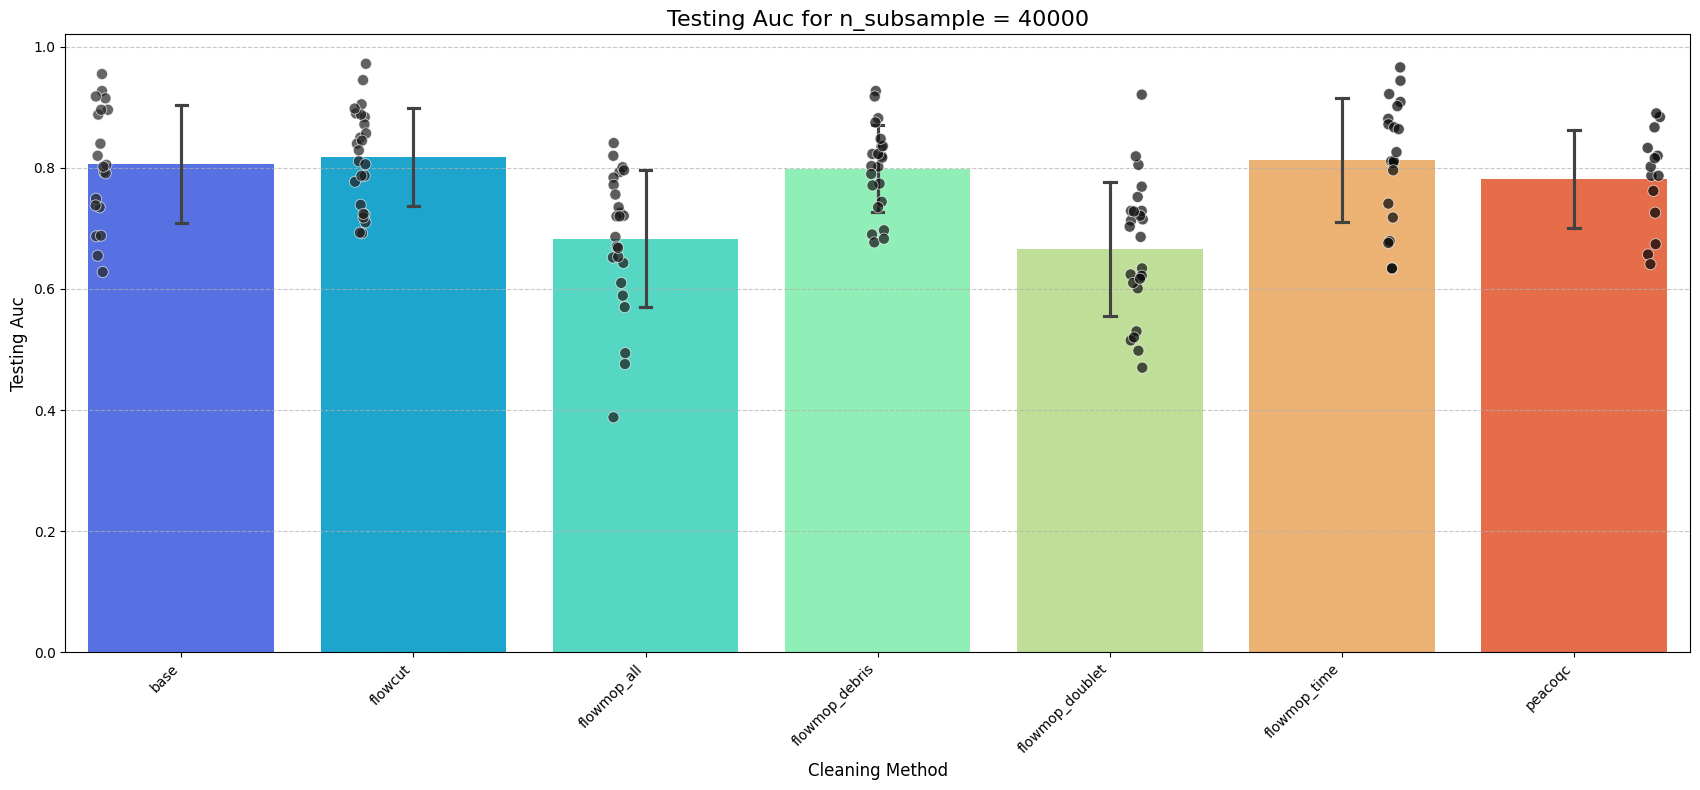

C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\3281902985.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\3281902985.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


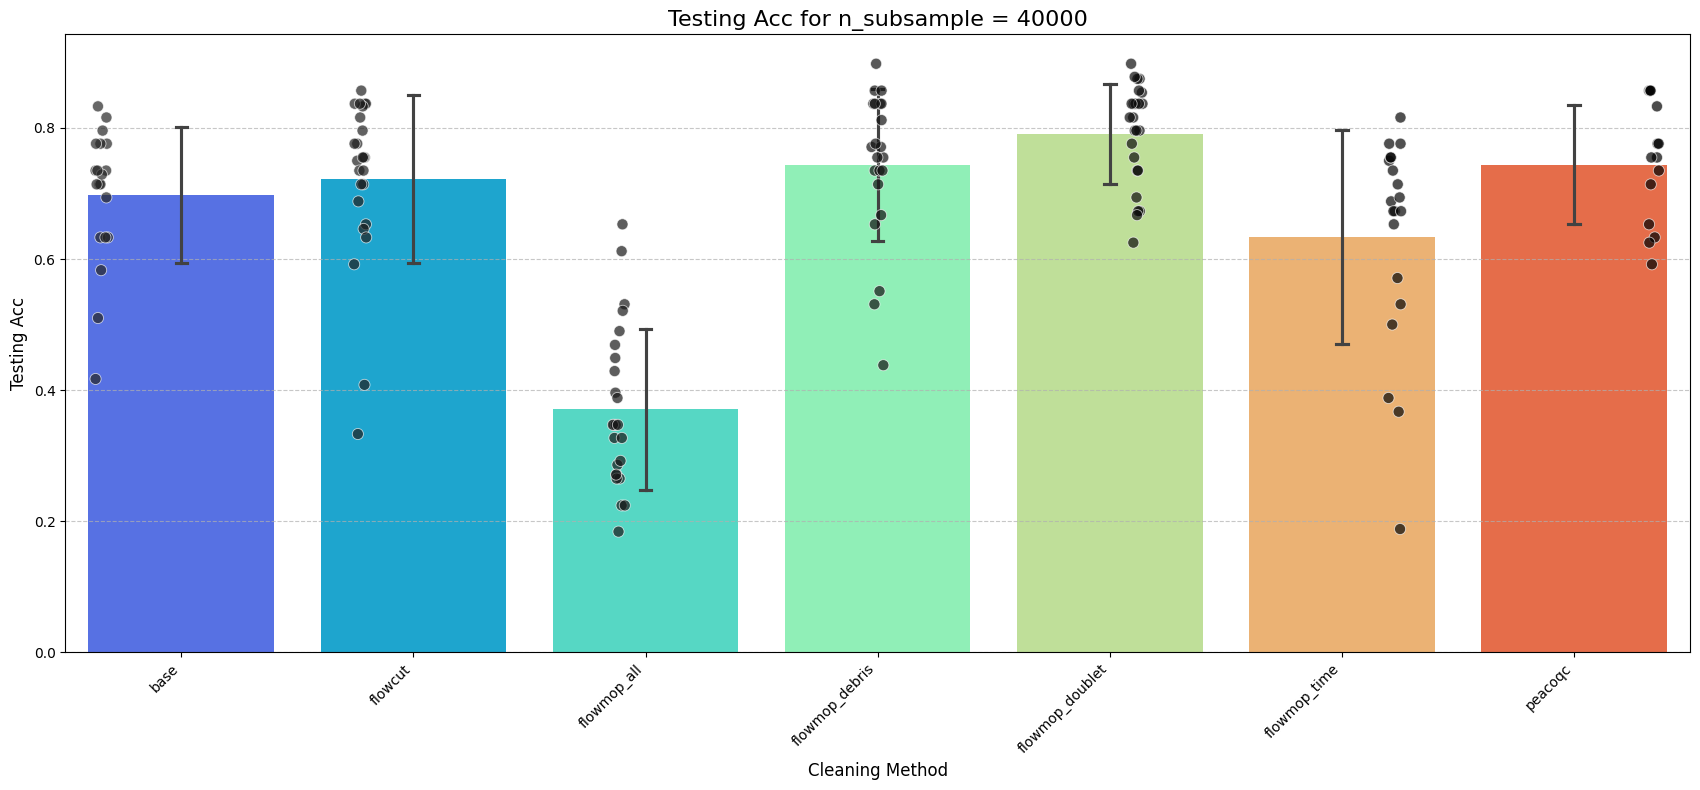

C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\3281902985.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax_top, **plot_kwargs)
C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\3281902985.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(ax=ax_top, **strip_kwargs)
C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\3281902985.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax_bottom, **plot_kwargs)
C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\3281902985.py:110: FutureWarning: 

Passing `palette` without assigning 

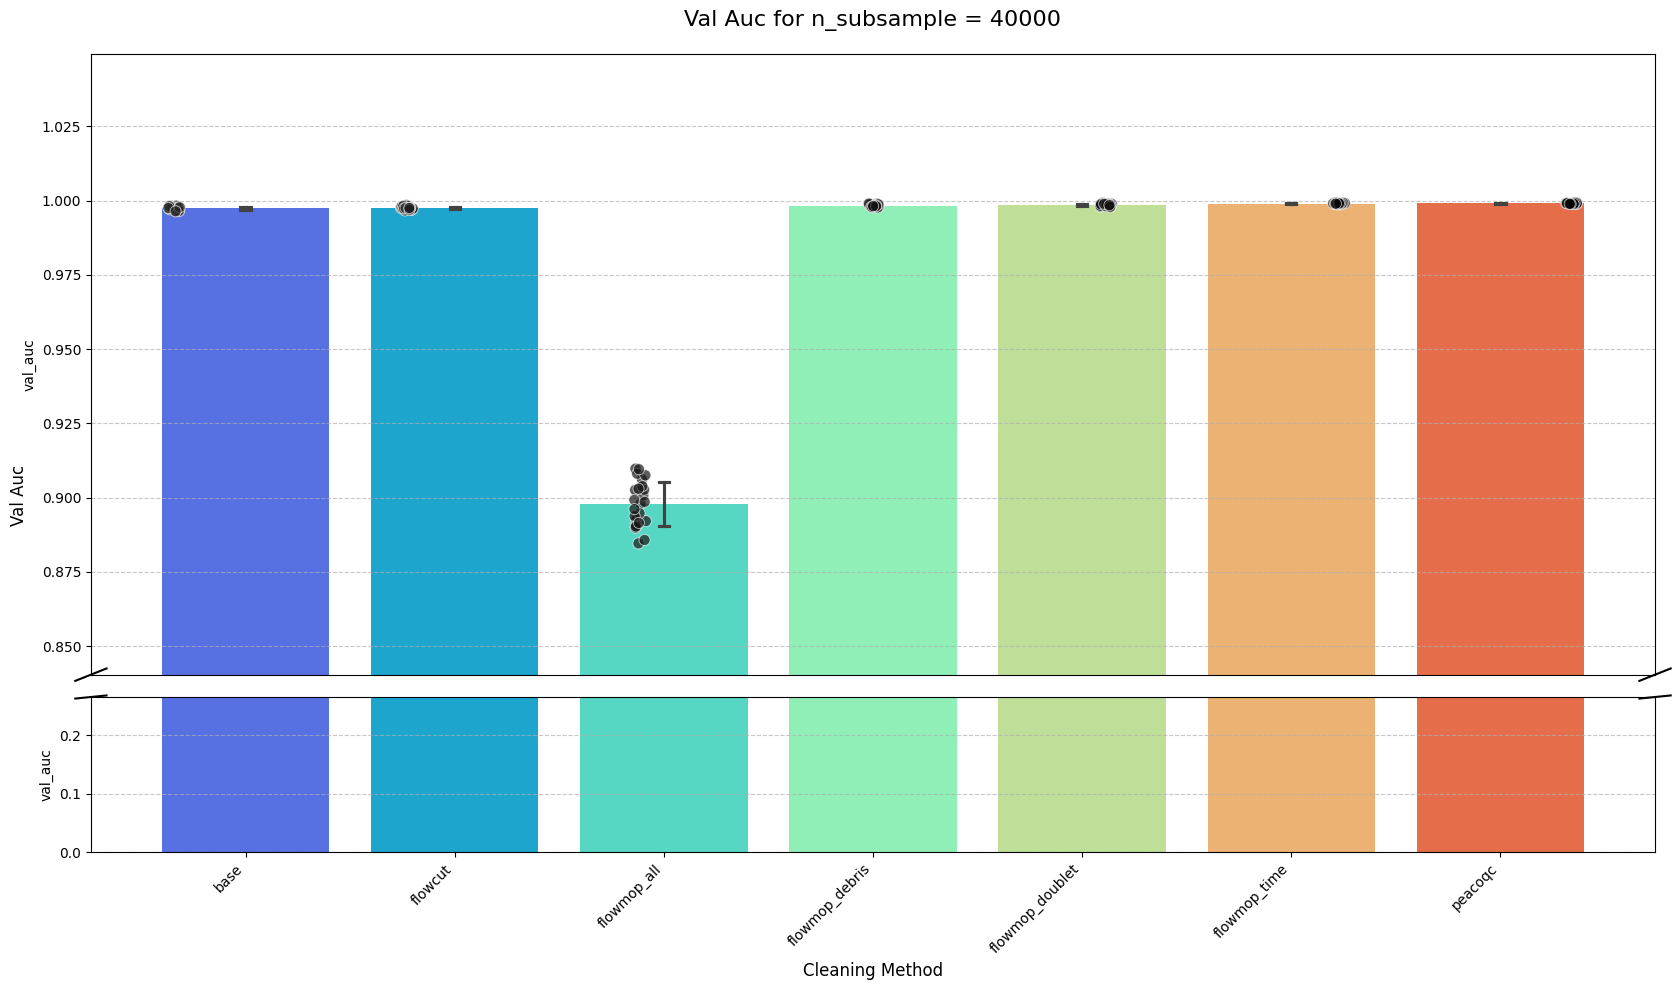

C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\3281902985.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax_top, **plot_kwargs)
C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\3281902985.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(ax=ax_top, **strip_kwargs)
C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\3281902985.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax_bottom, **plot_kwargs)
C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\3281902985.py:110: FutureWarning: 

Passing `palette` without assigning 

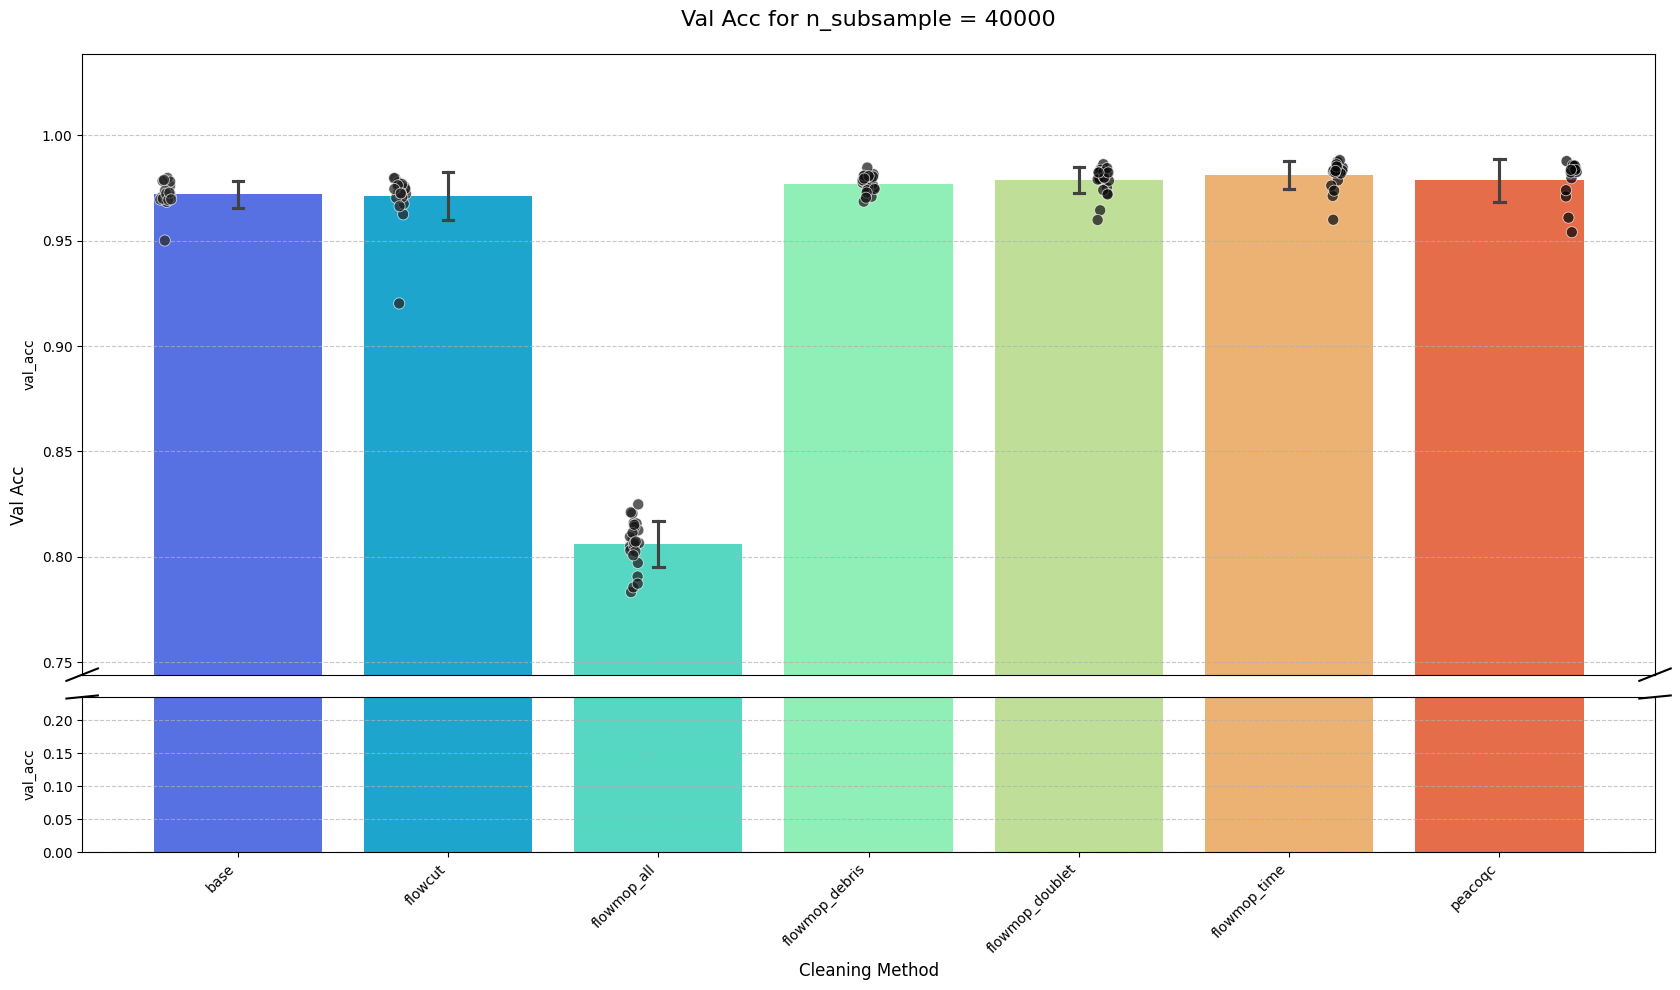

C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\3281902985.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax_top, **plot_kwargs)
C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\3281902985.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(ax=ax_top, **strip_kwargs)
C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\3281902985.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax_bottom, **plot_kwargs)
C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\3281902985.py:110: FutureWarning: 

Passing `palette` without assigning 

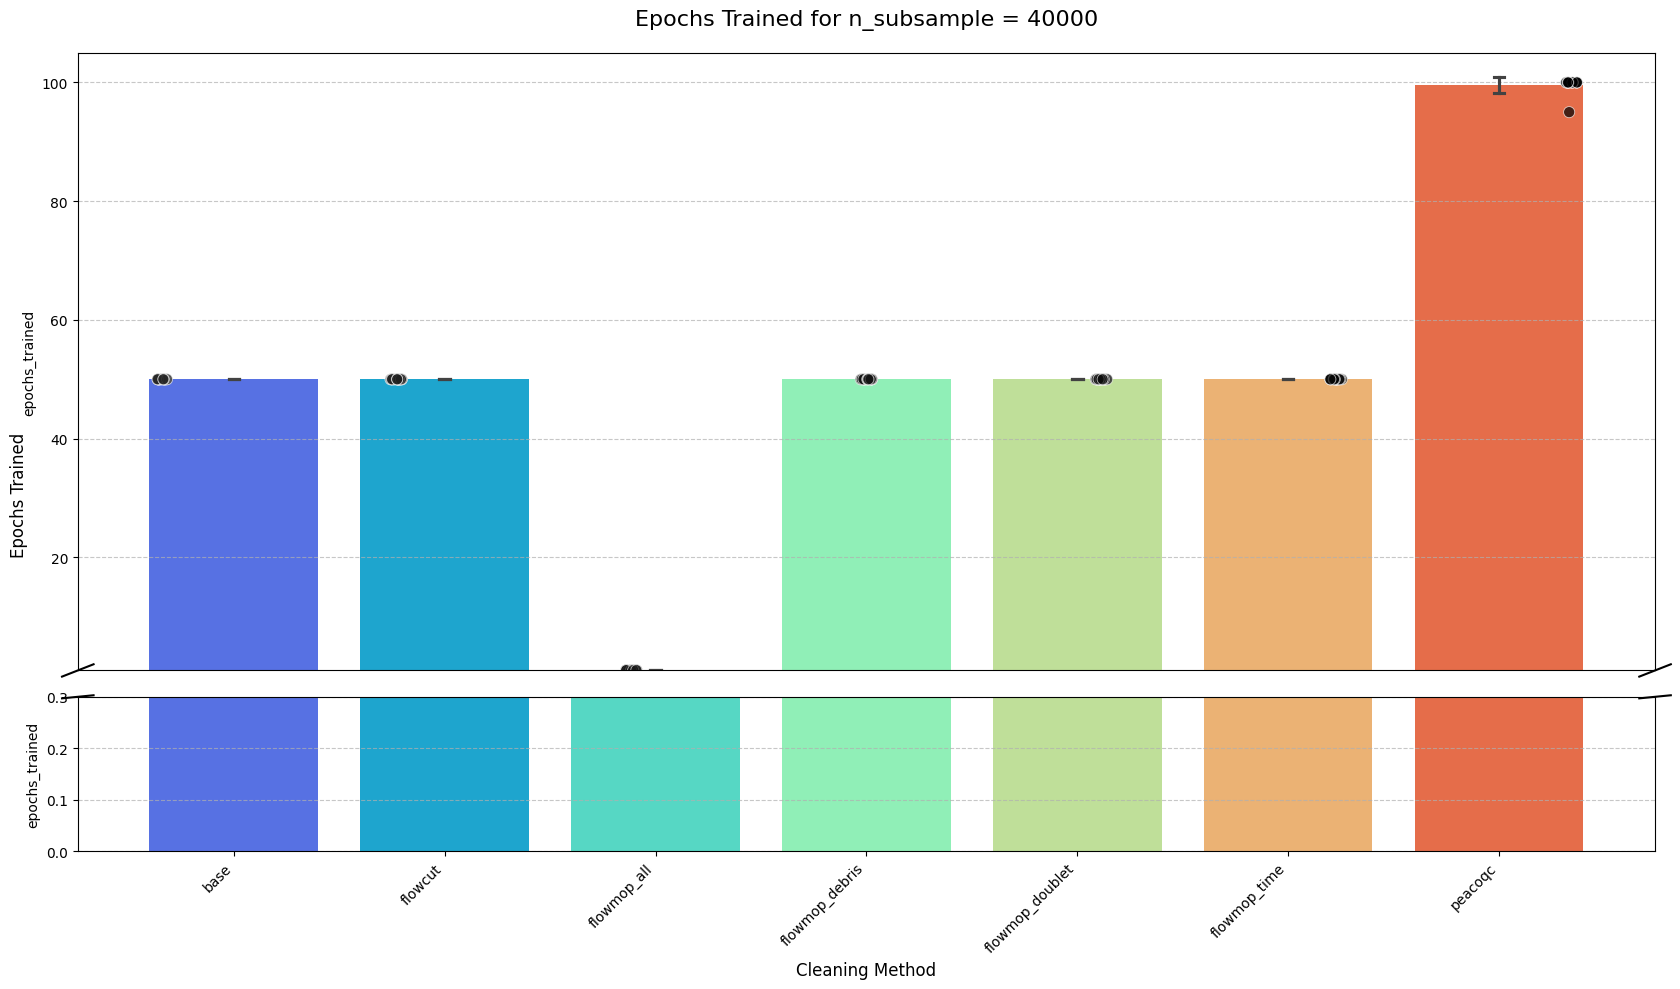

C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\3281902985.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\3281902985.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


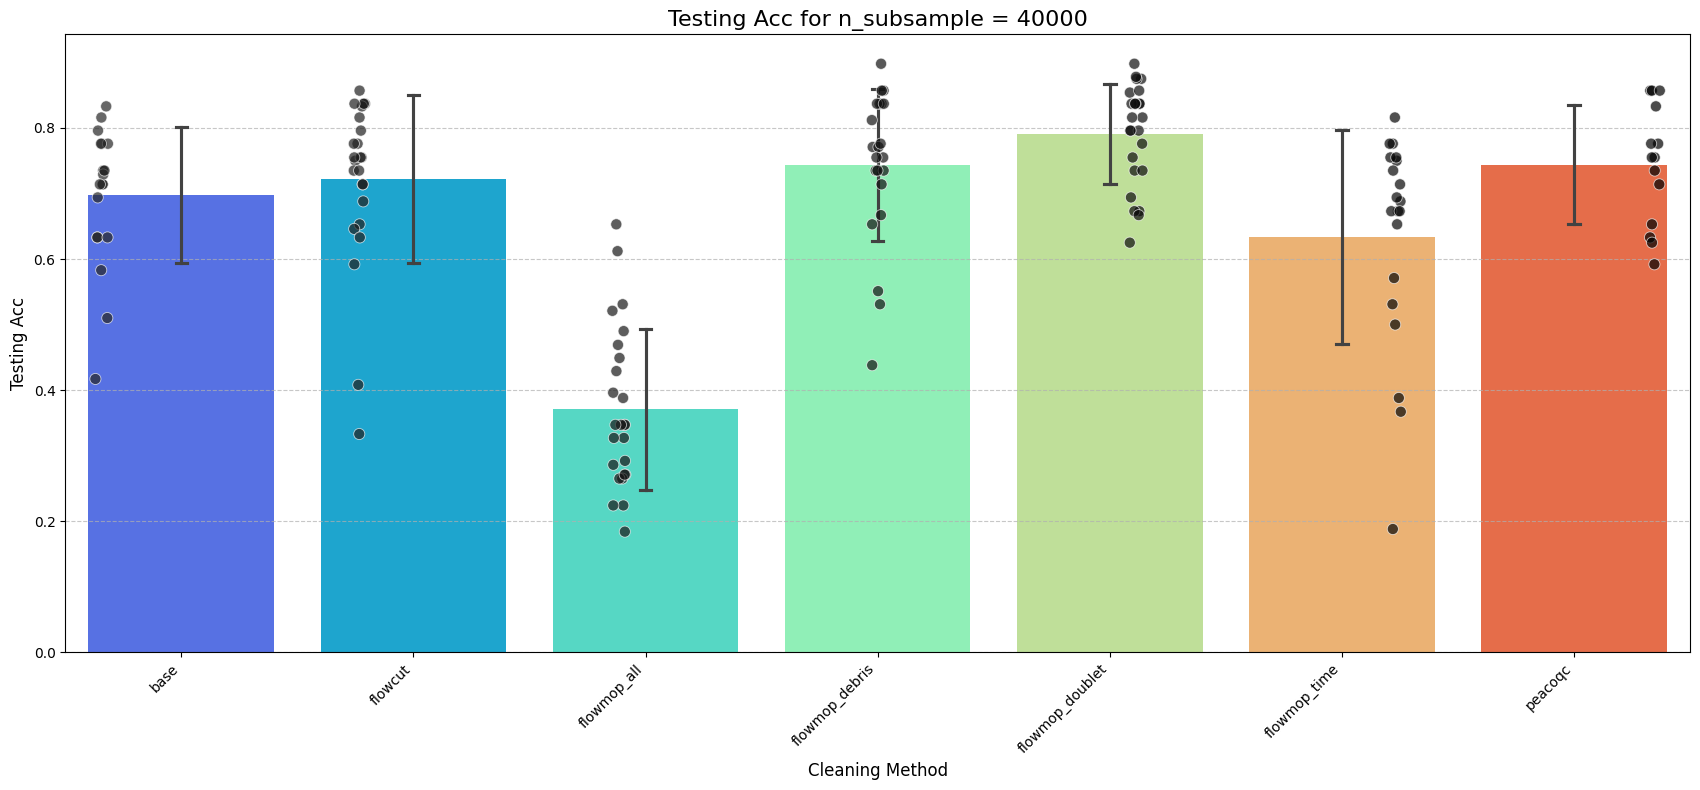

C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\3281902985.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax_top, **plot_kwargs)
C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\3281902985.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(ax=ax_top, **strip_kwargs)
C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\3281902985.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax_bottom, **plot_kwargs)
C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\3281902985.py:110: FutureWarning: 

Passing `palette` without assigning 

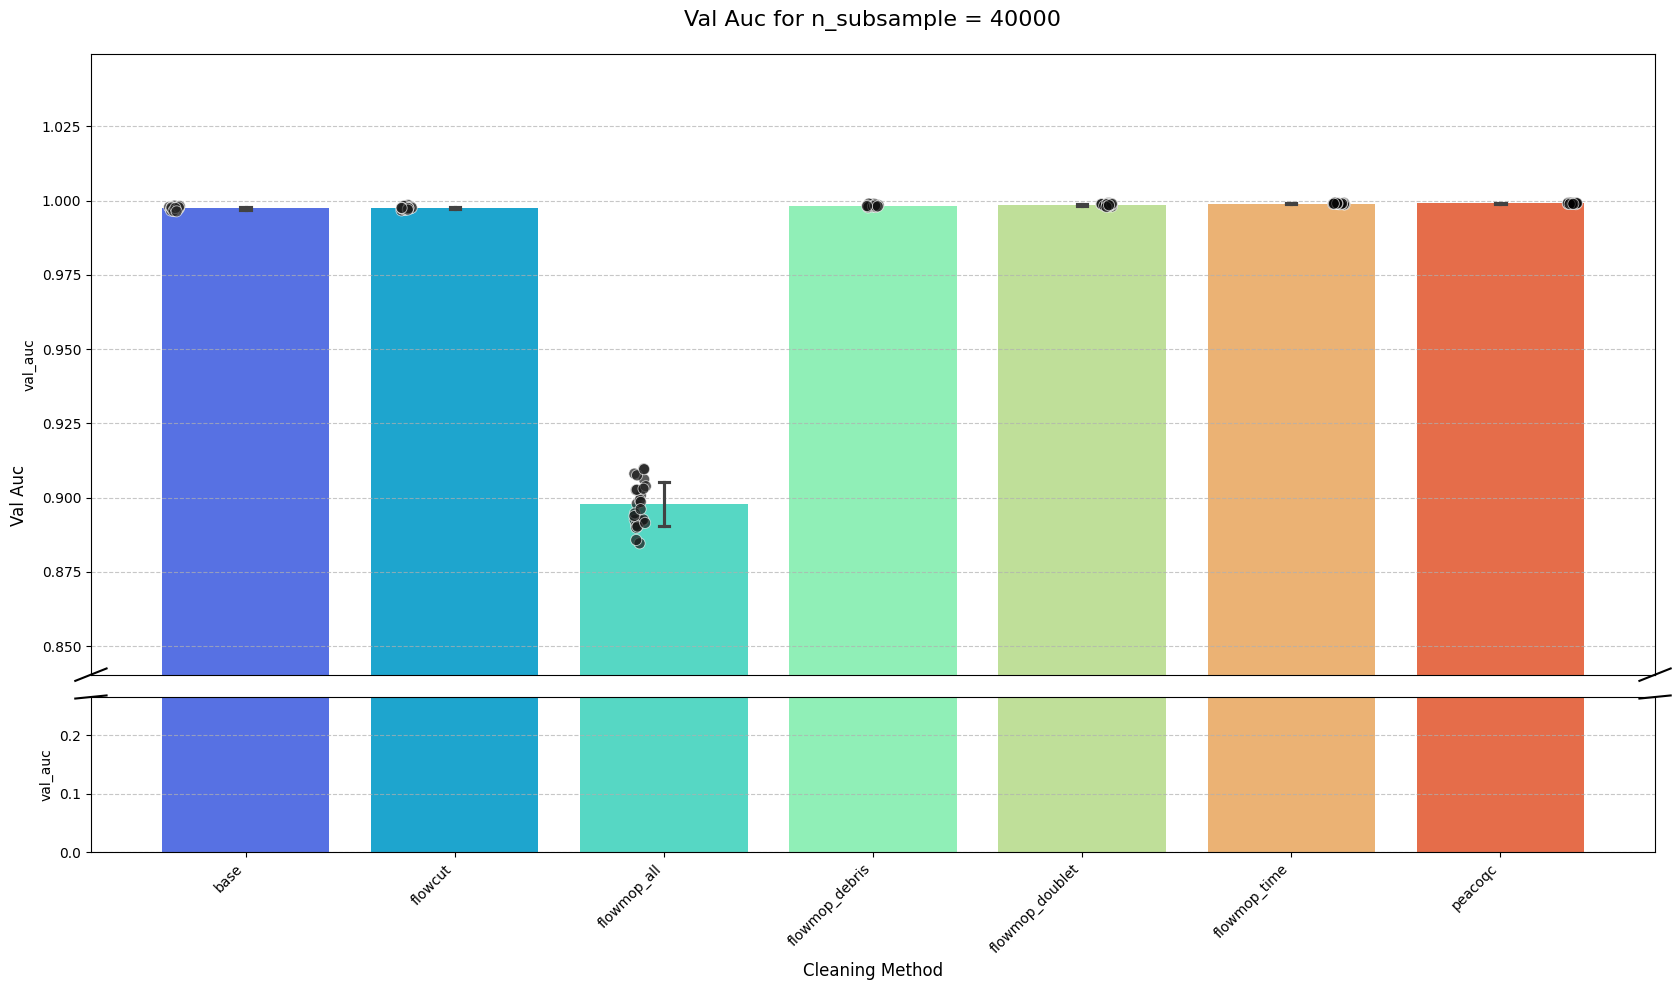

C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\3281902985.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax_top, **plot_kwargs)
C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\3281902985.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(ax=ax_top, **strip_kwargs)
C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\3281902985.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax_bottom, **plot_kwargs)
C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\3281902985.py:110: FutureWarning: 

Passing `palette` without assigning 

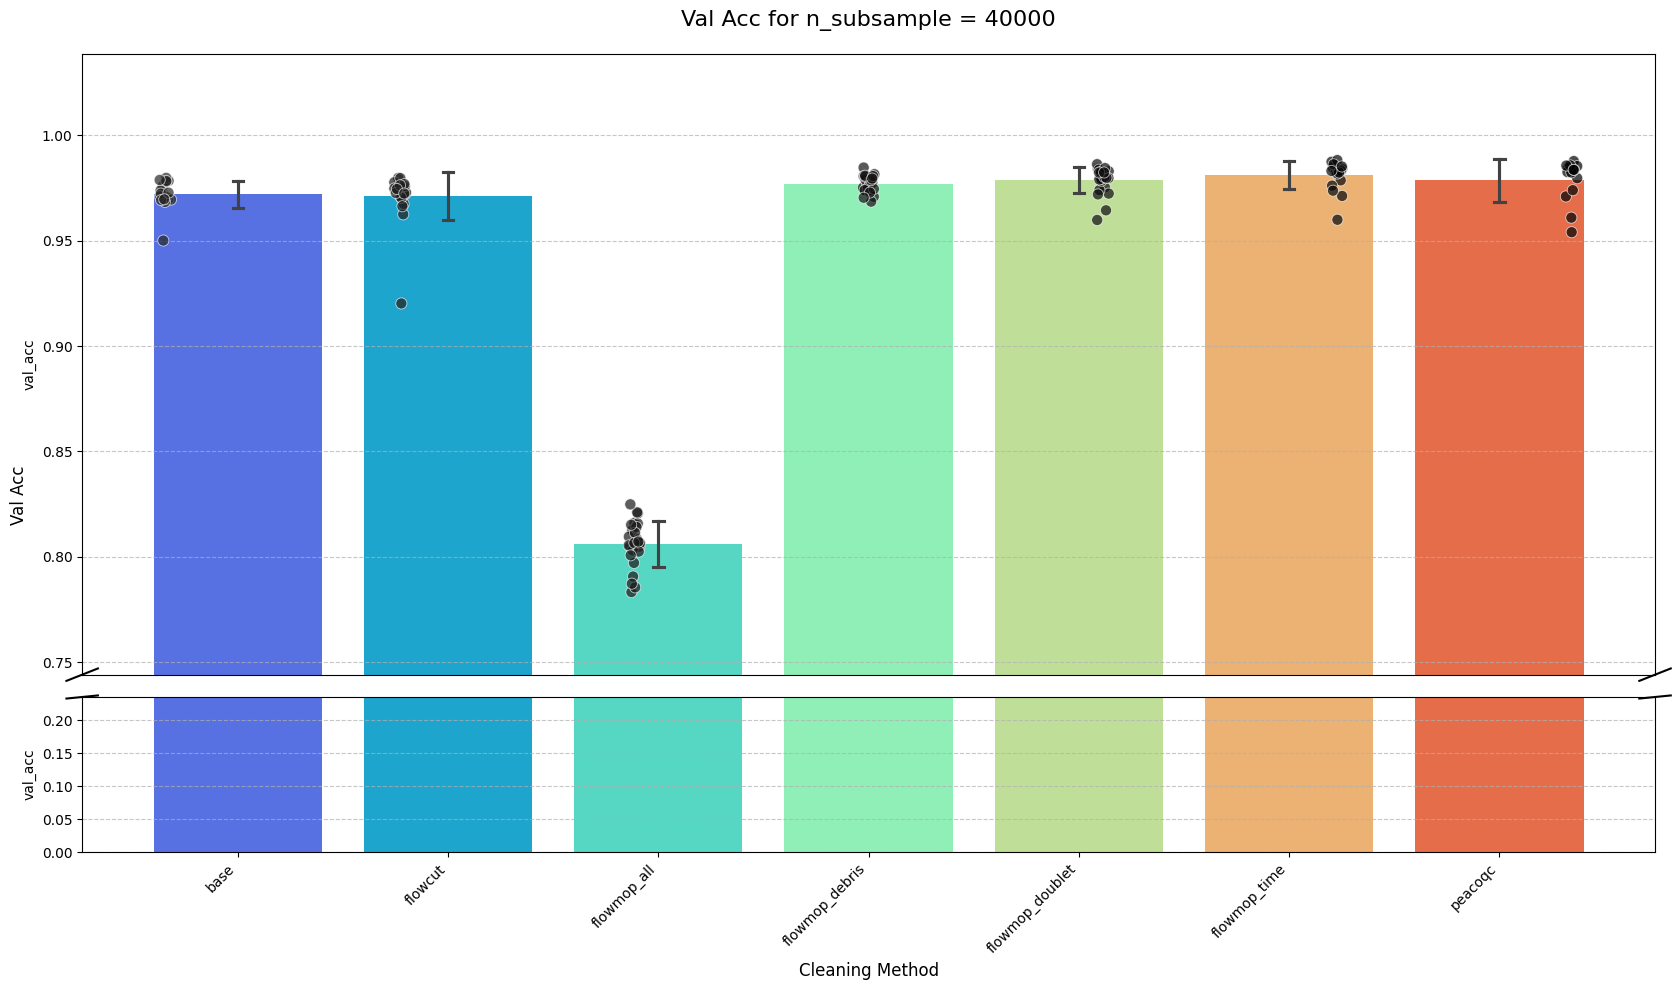

In [125]:

# --- Generate Multi-bar Plots ---
plot_metric_multibar(results, metric='testing_auc', nsubsample=40000)
plot_metric_multibar(results, metric='testing_acc', nsubsample=40000)
plot_metric_multibar(results, metric='val_auc', nsubsample=40000)
plot_metric_multibar(results, metric='val_acc', nsubsample=40000)
plot_metric_multibar(results, metric='epochs_trained', nsubsample=40000)
plot_metric_multibar(results, metric='testing_acc', nsubsample=40000)
plot_metric_multibar(results, metric='val_auc', nsubsample=40000)
plot_metric_multibar(results, metric='val_acc', nsubsample=40000)

In [75]:
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from typing import Optional
import pandas as pd

def perform_anova_and_tukey(
    df: pd.DataFrame,
    metric: str,
    nsubsample: int,
    alpha: float = 0.05
) -> Optional[pd.DataFrame]:
    """Performs a one-way ANOVA and a Tukey HSD post-hoc test.

    This function filters for a specific n_subsample,
    runs an ANOVA, and if significant, performs a Tukey HSD test.

    Args:
        df (pd.DataFrame): The dataframe with experiment results.
        metric (str): The metric to be tested (e.g., 'testing_auc').
        nsubsample (int): The subsample size to filter by.
        alpha (float, optional): The significance level. Defaults to 0.05.

    Returns:
        Optional[pd.DataFrame]: DataFrame with significant Tukey HSD results, or None if not significant.
    
    Raises:
        KeyError: If required columns are missing in the DataFrame.
        ValueError: If less than two groups are present for ANOVA.
    
    Example:
        >>> sig_results = perform_anova_and_tukey(results, 'testing_auc', 40000)
        >>> if sig_results is not None:
        ...     print(sig_results)
    """
    # Filter for the specified nsubsample and non-null metric values
    subset = df[(df['nsubsample'] == nsubsample) & (df[metric].notna())].copy()

    # Group by cleaning_method for ANOVA
    groups = subset.groupby('cleaning_method')[metric].apply(list)

    if len(groups) < 2:
        return None

    # One-way ANOVA
    _, p_val = stats.f_oneway(*groups)

    # Tukey HSD post-hoc test
    tukey_results = pairwise_tukeyhsd(
        endog=subset[metric],
        groups=subset['cleaning_method'],
        alpha=alpha
    )

    results_df = pd.DataFrame(
        data=tukey_results._results_table.data[1:],
        columns=tukey_results._results_table.data[0]
    )
    significant_results = results_df[results_df['reject'] == True]

    return significant_results if not significant_results.empty else None

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Optional

def add_stat_annotation(
    ax,
    df_plot: pd.DataFrame,
    metric: str,
    order: List[str],
    tukey_results: Optional[pd.DataFrame],
    all_annotations: List[Dict],
) -> None:
    """
    Adds statistical annotation brackets with robust collision avoidance.

    This function tracks all annotations drawn on the plot to prevent overlaps.

    Args:
        ax: The matplotlib Axes object to annotate.
        df_plot (pd.DataFrame): DataFrame containing the data to plot.
        metric (str): The metric to annotate (e.g., 'testing_auc').
        order (List[str]): The order of cleaning methods/categories.
        tukey_results (Optional[pd.DataFrame]): DataFrame with Tukey HSD results.
        all_annotations (List[Dict]): List to track annotation positions for collision avoidance.

    Returns:
        None

    Example:
        >>> add_stat_annotation(ax, df, 'testing_auc', ['A', 'B', 'C'], tukey_results, [])
    """
    if tukey_results is None or tukey_results.empty:
        return

    # --- Initial Setup ---
    bar_width = ax.patches[0].get_width() if ax.patches else 0.8

    # Compute the max y value for each cleaning method
    y_max_group = df_plot.groupby('cleaning_method')[metric].max()

    # --- Vertical Step Calculation ---
    y_min, y_max = ax.get_ylim()
    y_step = (y_max - y_min) * 0.035
    if y_step == 0:
        y_step = 0.03  # Fallback value

    # Sort pairs by distance to draw shorter brackets first (heuristic for cleaner plots)
    tukey_results = tukey_results.copy()
    tukey_results['dist'] = tukey_results.apply(
        lambda row: abs(order.index(row['group1']) - order.index(row['group2'])),
        axis=1,
    )
    sorted_results = tukey_results.sort_values('dist')

    for _, row in sorted_results.iterrows():
        group1, group2, p_adj = row['group1'], row['group2'], row['p-adj']

        if group1 not in order or group2 not in order:
            continue

        cat_idx1, cat_idx2 = order.index(group1), order.index(group2)
        x_start, x_end = min(cat_idx1, cat_idx2), max(cat_idx1, cat_idx2)

        y_bar_max = max(y_max_group.get(group1, 0), y_max_group.get(group2, 0))

        # --- Collision Detection ---
        max_y_colliding = 0
        for ann in all_annotations:
            # Check for horizontal overlap: (start1 < end2) and (start2 < end1)
            if (x_start < ann['x_end']) and (ann['x_start'] < x_end):
                if ann['y_pos'] > max_y_colliding:
                    max_y_colliding = ann['y_pos']

        # --- Position Calculation ---
        y_from_collision = max_y_colliding + y_step if max_y_colliding > 0 else 0
        y_from_bar = y_bar_max + y_step * 1.5

        y = max(y_from_collision, y_from_bar)

        # --- Drawing ---
        ax.plot(
            [x_start, x_start, x_end, x_end],
            [y, y + y_step * 0.2, y + y_step * 0.2, y],
            lw=1.5,
            c="k",
        )
        p_text = f"p={p_adj:.2f}" if p_adj >= 0.01 else "p<0.01"
        ax.text(
            (x_start + x_end) / 2,
            y + y_step * 0.3,
            p_text,
            ha="center",
            va="bottom",
            color="k",
            fontsize=9,
        )

        # Record this annotation's position and span for future collision checks
        all_annotations.append({"x_start": x_start, "x_end": x_end, "y_pos": y})


def plot_metric_with_stats(
    df: pd.DataFrame,
    metric: str,
    nsubsample: int,
    tukey_results: Optional[pd.DataFrame],
) -> None:
    """
    Generates a bar plot with statistical annotations (no training proportion/hue).

    Args:
        df (pd.DataFrame): DataFrame containing the data to plot.
        metric (str): The metric to plot (e.g., 'testing_auc').
        nsubsample (int): The subsample size to filter by.
        tukey_results (Optional[pd.DataFrame]): DataFrame with Tukey HSD results.

    Returns:
        None

    Example:
        >>> plot_metric_with_stats(results, 'testing_auc', 40000, tukey_results)
    """
    plt.figure(figsize=(16, 8))

    data_to_plot = df[df["nsubsample"] == nsubsample].copy()
    if data_to_plot.empty:
        print(f"No data to plot for nsubsample={nsubsample}, metric={metric}")
        return

    sorted_methods = sorted(data_to_plot["cleaning_method"].dropna().unique())

    ax = sns.barplot(
        data=data_to_plot,
        x="cleaning_method",
        y=metric,
        palette="rainbow",
        errorbar="sd",
        capsize=0.05,
        order=sorted_methods,
    )
    sns.stripplot(
        data=data_to_plot,
        x="cleaning_method",
        y=metric,
        color="black",
        linewidth=0.6,
        size=4,
        alpha=0.7,
        ax=ax,
        order=sorted_methods,
    )

    all_annotations: List[Dict] = []

    if tukey_results is not None:
        add_stat_annotation(ax, data_to_plot, metric, sorted_methods, tukey_results, all_annotations)

    plt.title(f"{metric.replace('_', ' ').title()} for n_subsample = {nsubsample}", fontsize=18)
    plt.xlabel("Cleaning Method", fontsize=14)
    plt.ylabel(f"Mean {metric.replace('_', ' ').title()}", fontsize=14)
    plt.xticks(rotation=45, ha="right", fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Dynamically adjust y-axis limit based on the highest annotation
    if all_annotations:
        y_range = df[metric].max() - df[metric].min()
        y_step = y_range * 0.05 if y_range > 0 else 0.05
        max_ann_y = max(ann["y_pos"] for ann in all_annotations)
        y_min, _ = ax.get_ylim()
        ax.set_ylim(y_min, max_ann_y + 4 * y_step)

    plt.tight_layout(rect=[0, 0, 0.95, 1])
    plt.show()


C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\2882180429.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = subset.groupby('cleaning_method')[metric].apply(list)
C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\1887050191.py:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\1887050191.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  y_max_group = df_plot.groupby('cleaning_method')[metric]

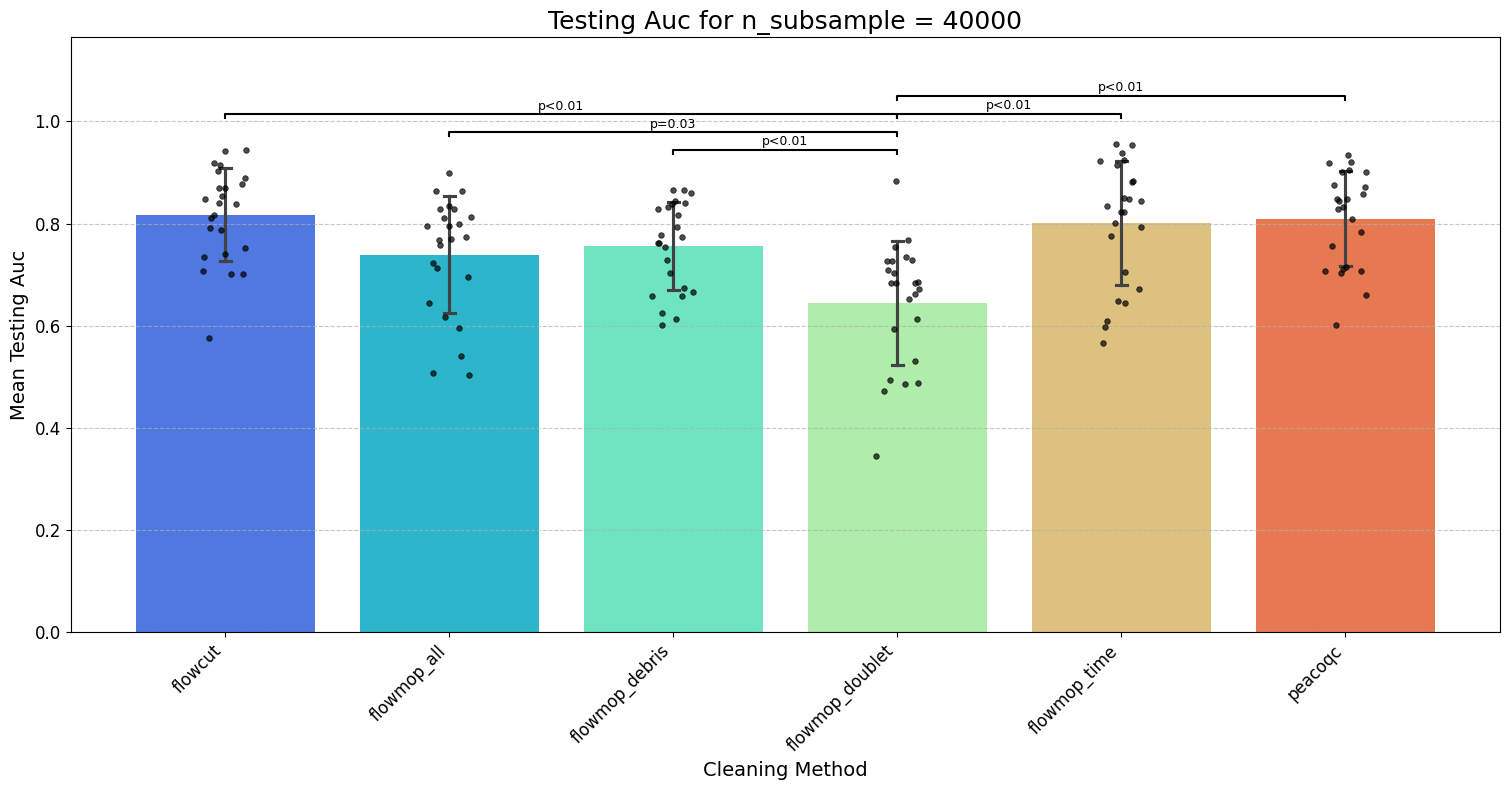

C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\2882180429.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = subset.groupby('cleaning_method')[metric].apply(list)
C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\1887050191.py:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\1887050191.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  y_max_group = df_plot.groupby('cleaning_method')[metric]

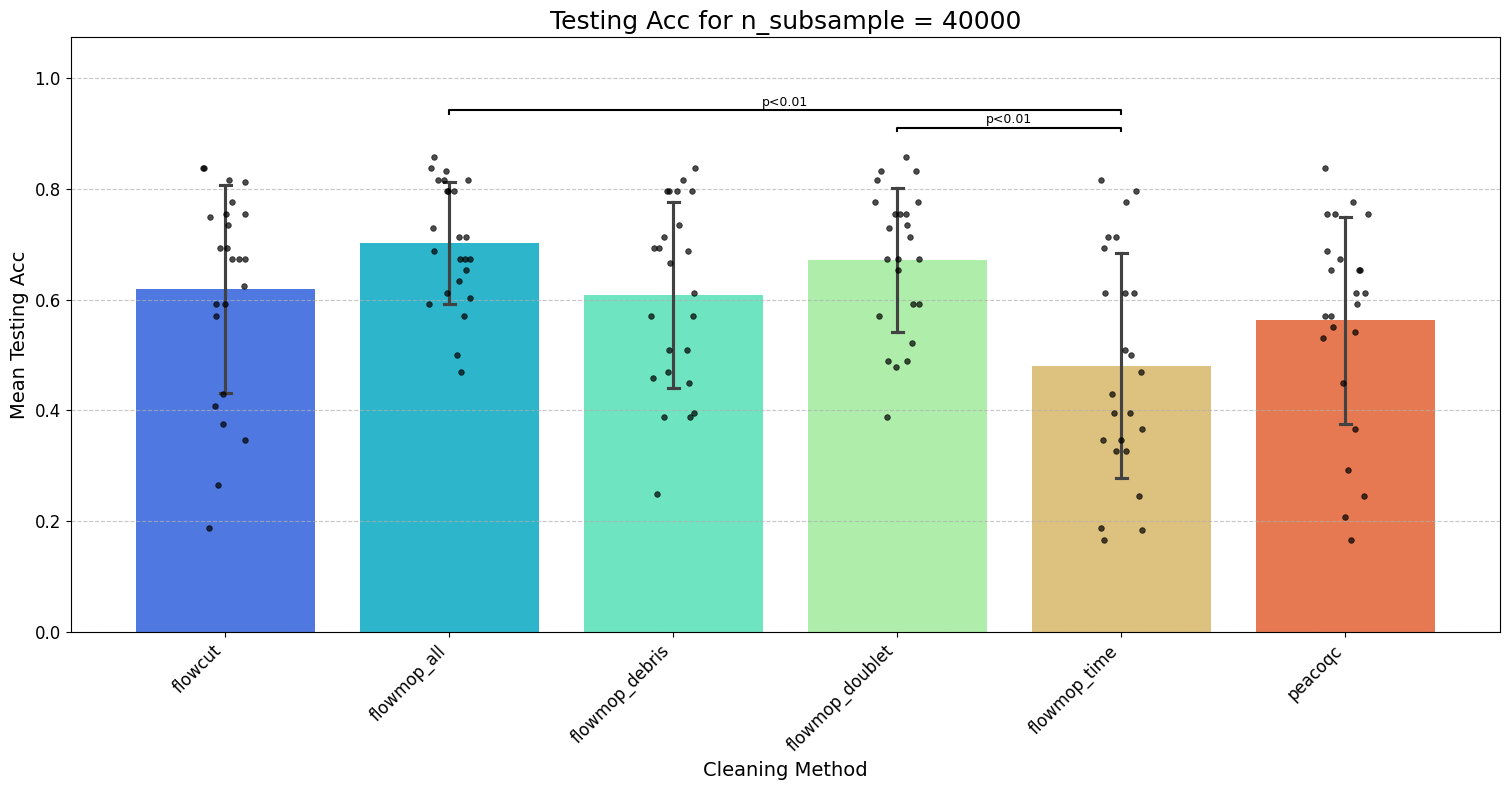

C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\2882180429.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = subset.groupby('cleaning_method')[metric].apply(list)
C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\1887050191.py:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


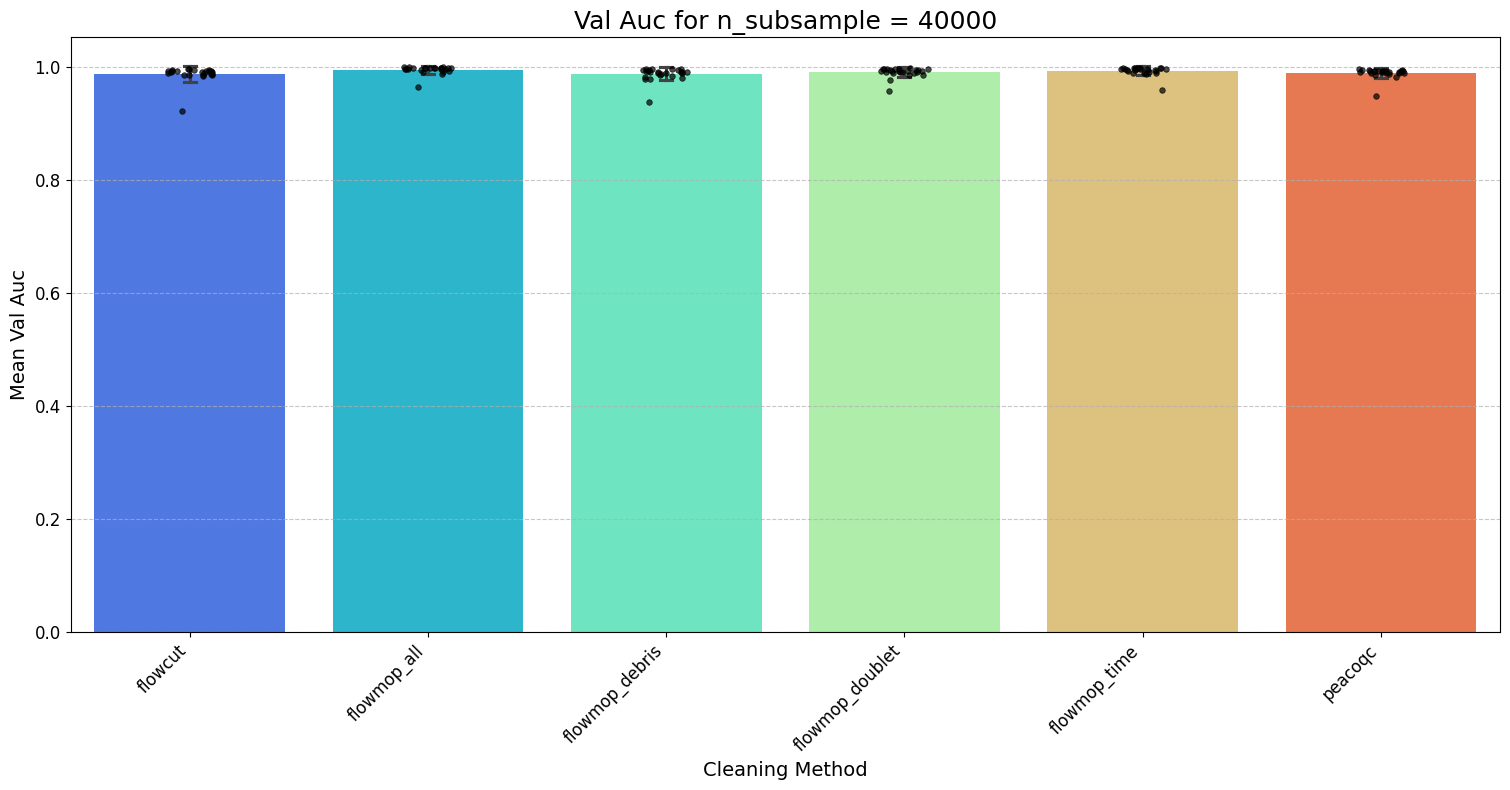

C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\2882180429.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = subset.groupby('cleaning_method')[metric].apply(list)
C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\1887050191.py:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
C:\Users\Tony\AppData\Local\Temp\ipykernel_26240\1887050191.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  y_max_group = df_plot.groupby('cleaning_method')[metric]

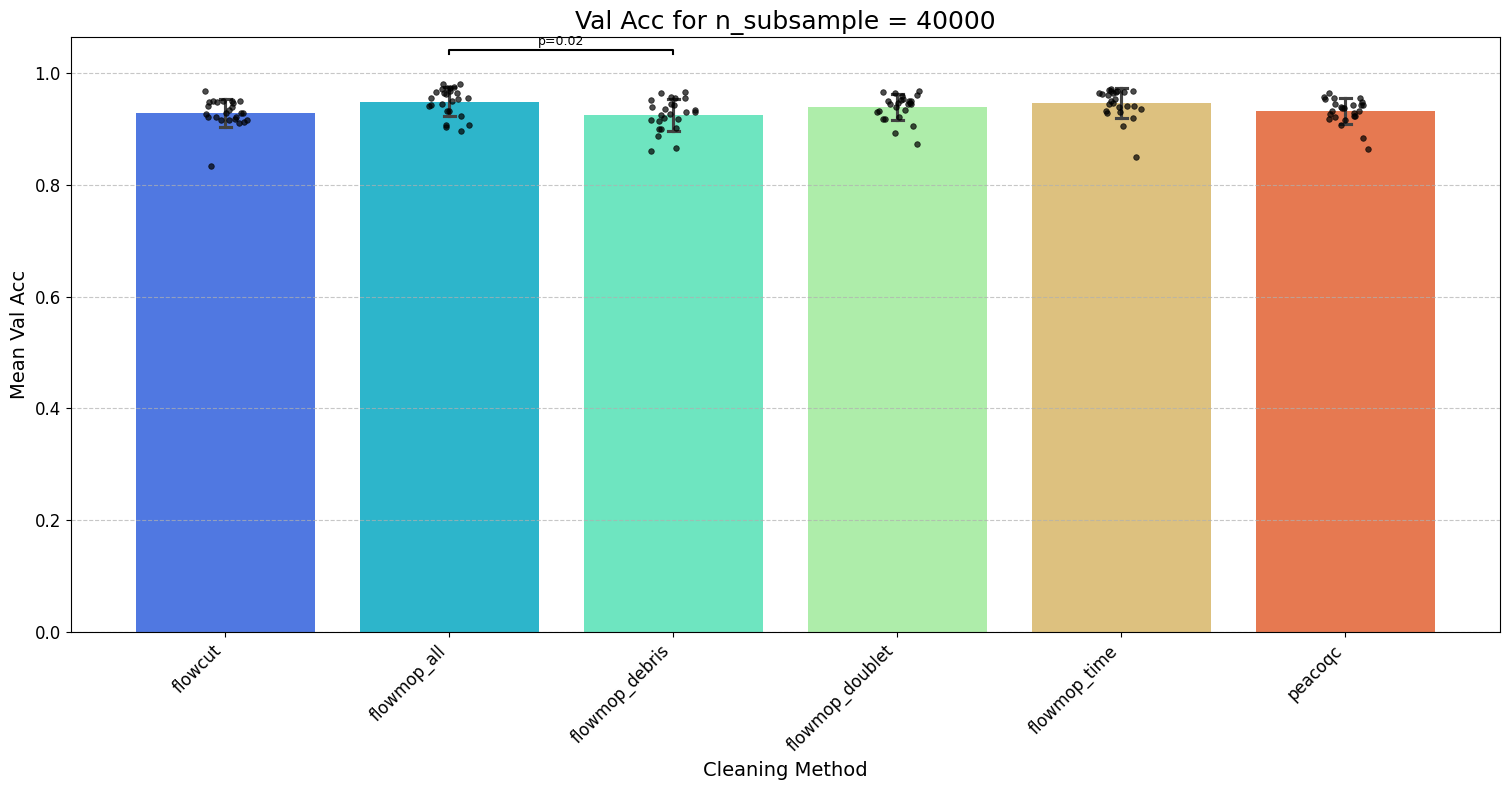

Skipping n_subsample=20000 as no data is available.


In [77]:
# --- Integrated Analysis and Plotting (No Training Proportion) ---
metrics_to_test = ['testing_auc', 'testing_acc', 'val_auc', 'val_acc']
n_subsamples_to_test = [40000, 20000]

# Ensure the 'results' DataFrame is available from the initial cells
for n_sub in n_subsamples_to_test:
    df_nsub = results[results['nsubsample'] == n_sub]
    if df_nsub.empty:
        print(f"Skipping n_subsample={n_sub} as no data is available.")
        continue

    for metric in metrics_to_test:
        tukey_res = perform_anova_and_tukey(results, metric, n_sub)
        tukey_results_all_props = None
        if tukey_res is not None:
            tukey_results_all_props = tukey_res
        plot_metric_with_stats(results, metric, n_sub, tukey_results_all_props)